## Logistic Regression model to predict Heart Disease

### Import Libraries

In [48]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(
    action='ignore', module='matplotlib.figure', category=UserWarning,
    message=('This figure includes Axes that are not compatible with tight_layout, '
             'so results might be incorrect.')
)

In [2]:
#!pip install -U imbalanced-learn --upgrade

In [3]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler, LabelEncoder,OneHotEncoder,StandardScaler,MaxAbsScaler,Normalizer
from sklearn.model_selection import cross_val_score, train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from imblearn.over_sampling import SMOTE
from collections import Counter

### Download the Dataset

In [4]:
od.download('https://www.kaggle.com/datasets/thedevastator/predicting-heart-disease-risk-using-clinical-var/data')

Skipping, found downloaded files in ".\predicting-heart-disease-risk-using-clinical-var" (use force=True to force download)


In [5]:
df = pd.read_csv('.\\predicting-heart-disease-risk-using-clinical-var\Heart_Disease_Prediction.csv')
df.head(5)                 

,index,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


### Interpretation
1. The data set is simple data set with 13 features
2. The goal is to predict if the person has a probable heart disease
3. The target variable is heart disease which needs to be encoded

### Now lets do the basic validation

In [6]:
df.shape
df.isna().sum()
df.isnull().sum()
df.duplicated().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    270 non-null    int64  
 1   Age                      270 non-null    int64  
 2   Sex                      270 non-null    int64  
 3   Chest pain type          270 non-null    int64  
 4   BP                       270 non-null    int64  
 5   Cholesterol              270 non-null    int64  
 6   FBS over 120             270 non-null    int64  
 7   EKG results              270 non-null    int64  
 8   Max HR                   270 non-null    int64  
 9   Exercise angina          270 non-null    int64  
 10  ST depression            270 non-null    float64
 11  Slope of ST              270 non-null    int64  
 12  Number of vessels fluro  270 non-null    int64  
 13  Thallium                 270 non-null    int64  
 14  Heart Disease            2

### Interpretation 
1. There are no null or nan values found
2. There is no duplicate values
3. Only the target variable is categorical which needs to be encoded

### Performing the basic statistical description

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
index,270.0,134.500000,78.086491,0.0,67.25,134.5,201.75,269.0
Age,270.0,54.433333,9.109067,29.0,48.00,55.0,61.00,77.0
Sex,270.0,0.677778,0.468195,0.0,0.00,1.0,1.00,1.0
Chest pain type,270.0,3.174074,0.950090,1.0,3.00,3.0,4.00,4.0
BP,270.0,131.344444,17.861608,94.0,120.00,130.0,140.00,200.0
Cholesterol,270.0,249.659259,51.686237,126.0,213.00,245.0,280.00,564.0
FBS over 120,270.0,0.148148,0.355906,0.0,0.00,0.0,0.00,1.0
EKG results,270.0,1.022222,0.997891,0.0,0.00,2.0,2.00,2.0
Max HR,270.0,149.677778,23.165717,71.0,133.00,153.5,166.00,202.0
Exercise angina,270.0,0.329630,0.470952,0.0,0.00,0.0,1.00,1.0


### Interpretation
1. At high level glance looks like the Cholestrol is right skewed as the min range is 126 and 75% is 280 but max range in  564
2. The age looks like normaly distributed
2. Slight skewness can be seen in BP, Cholestrol,Thallium, ST Depression
Lets check our interpretation using the kde plot
    

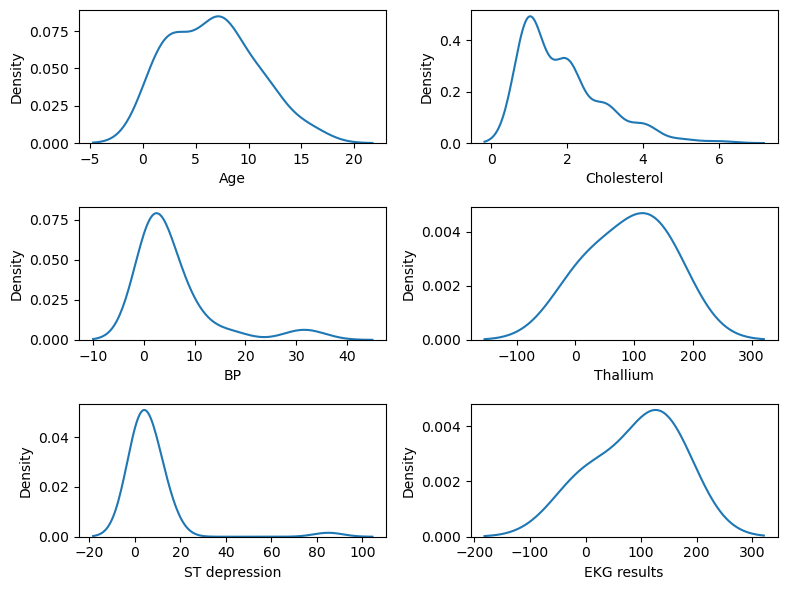

In [8]:
skewed_cols = ['Age','Cholesterol','BP','Thallium','ST depression','EKG results']
fig, ax= plt.subplots(nrows =3,ncols=2,figsize = (8,6))
j = 0
k = 0
for i,col in enumerate(skewed_cols): 
    if i == 0:
        j = 0
        k = 0
    elif i%2 == 0:        
        j = j + 1
        k = 0
    else: 
        k = k + 1        
    fig.tight_layout()
    ax[j,k].set_xlabel(col)
    sns.kdeplot(data=df[col].value_counts(),x=df[col].value_counts().values,ax=ax[j,k])     

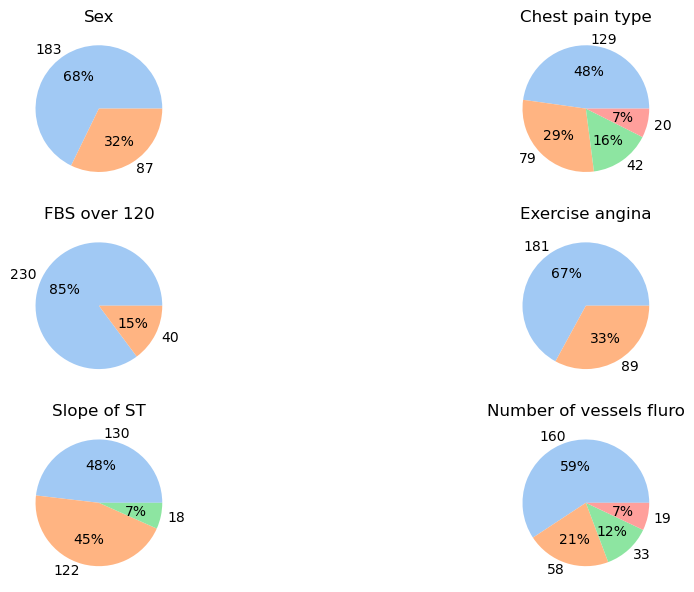

In [9]:
cat_cols = ['Sex','Chest pain type','FBS over 120','Exercise angina','Slope of ST','Number of vessels fluro']
fig, ax = plt.subplots(nrows=3,ncols=2,figsize =(10,8))
j = 0
k = 0
for i,col in enumerate(cat_cols):
    if i == 0:
        j = 0
        k = 0
    elif i%2 == 0:        
        j = j + 1
        k = 0
    else: 
        k = k + 1       
    ax = plt.subplot2grid((4,2),(j,k))
    fig.tight_layout()
    plt.title(col)
    plt.pie(x=df[col].value_counts(),labels=df[col].value_counts().values,colors=sns.color_palette('pastel'),
           autopct='%.0f%%')
    

### Finding outliers in the data

<Axes: >

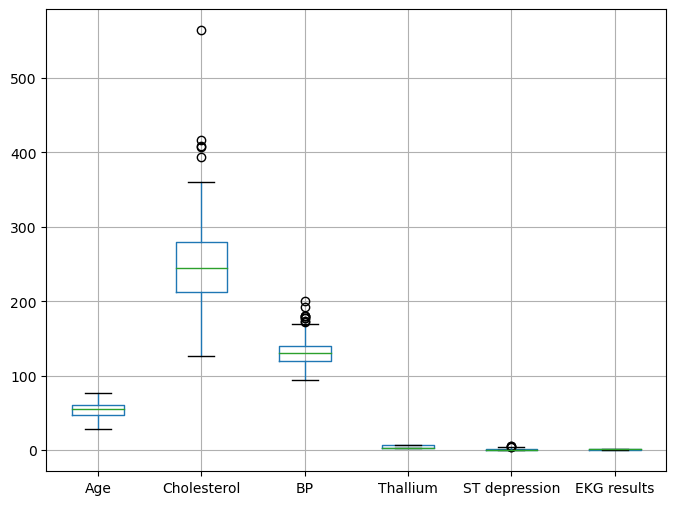

In [10]:
fig = plt.figure(figsize=(8,6))
df.boxplot(column=skewed_cols)

### Interpretation
1. Cholestrol , BP and ST Depression are having outliers
2. First we need to bcheck the count of outliers
2. If the count is less we can choose to drop, if more we can try to impute them
Lets check our interpretation by calucating the Inter quarile Range (IQR)
    

In [11]:
outlier_cols = ['Cholesterol', 'BP', 'ST depression']
for i,col in enumerate(outlier_cols):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3  - q1
    lower_fence = q1 - 1.5 * (iqr)
    upper_fence = q3 + 1.5 * (iqr)
    lower_fence_cnt = df[(df[col]< lower_fence)][col].count()
    upper_fence_cnt = df[(df[col]> upper_fence)][col].count()
    print(f"The Lower fence  {lower_fence} and upper fence {upper_fence}")
    print(f"The total outliers in {col} = {lower_fence_cnt},{upper_fence_cnt}")

The Lower fence  112.5 and upper fence 380.5
The total outliers in Cholesterol = 0,5
The Lower fence  90.0 and upper fence 170.0
The total outliers in BP = 0,9
The Lower fence  -2.4000000000000004 and upper fence 4.0
The total outliers in ST depression = 0,4


### Replace outliers based on mode or median for the similar age

In [12]:
for col in outlier_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3  - q1
    lower_fence = q1 - 1.5 * (iqr)
    upper_fence = q3 + 1.5 * (iqr)
    ind = df[ (df[col]< lower_fence) | (df[col]> upper_fence)] [col].index
    for i in ind:       
        age = df['Age'].iloc[i]
        ch_mode = df[df['Age']== age] [col].mode()
        if ch_mode.count() == 1:
            df[col].iloc[i] = ch_mode 
            #print( df[col].iloc[i])
        else:
            df[col].iloc[i] = df[df['Age']== age] [col].median()
            #print( df[col].iloc[i])

<Axes: >

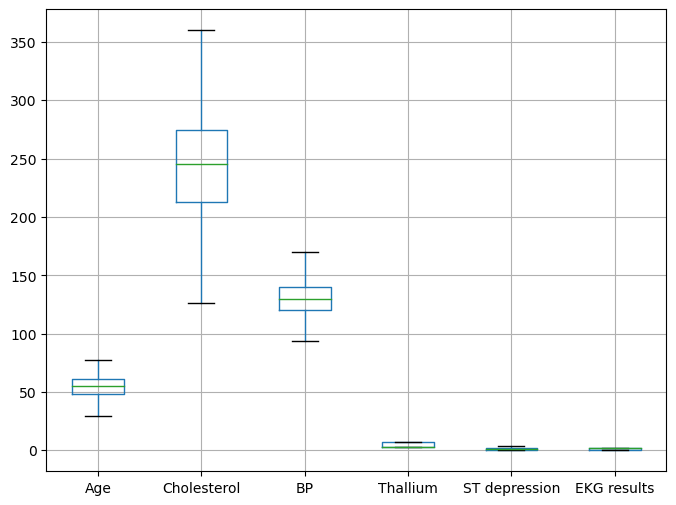

In [13]:
fig = plt.figure(figsize=(8,6))
df.boxplot(column=skewed_cols)

### Encode the target variable

In [14]:
label = LabelEncoder()
df['Heart Disease_encoded'] = label.fit_transform(df['Heart Disease'])

In [15]:
### Checking Correlation

<Axes: >

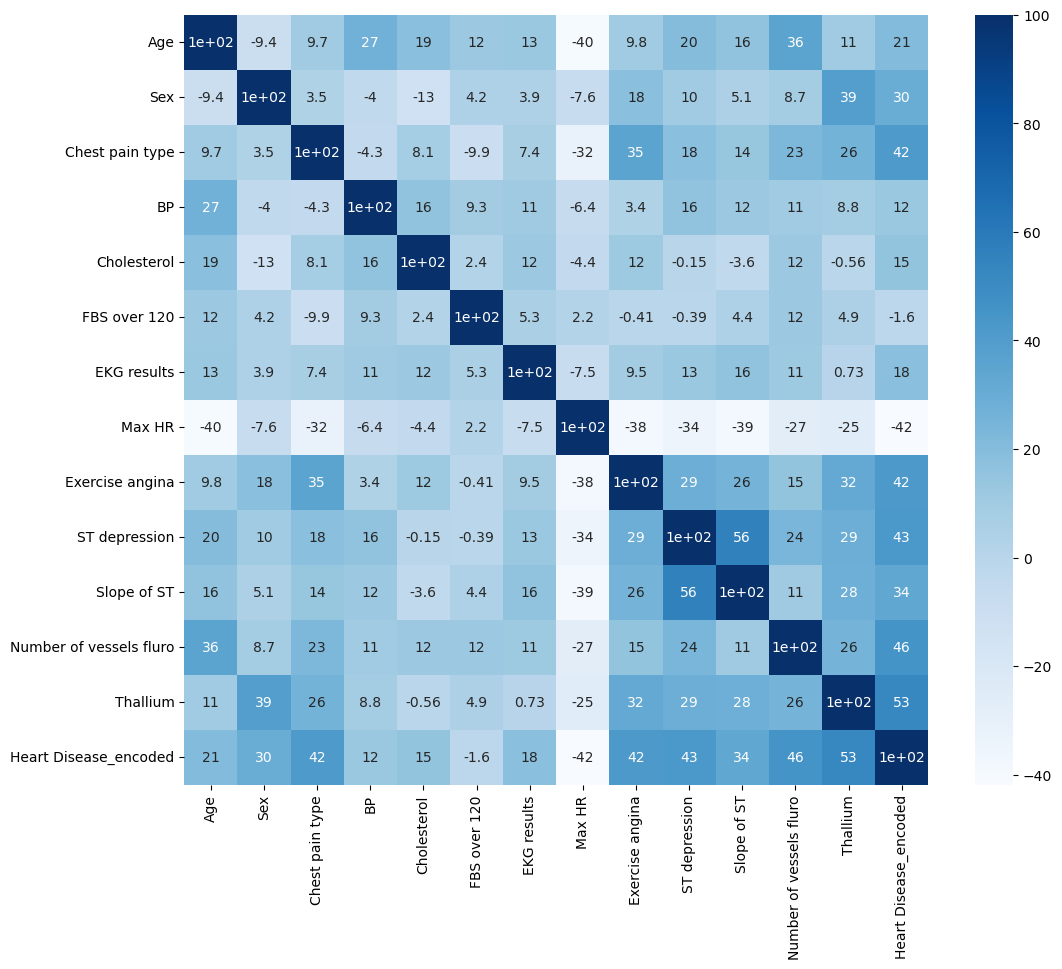

In [16]:
numeric_col = [ 'Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol',
       'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina',
       'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium',
        'Heart Disease_encoded']
plt.figure(figsize=(12,10))
sns.heatmap(data= df[numeric_col].corr()*100,annot=True,cmap='Blues')

### As known there is no correlation between the features
Lets verify with Varaince Inflation Factor

In [17]:
df.columns
vif_cols = [ 'Sex','Chest pain type','BP',  'Cholesterol', 'Age','Thallium', 'Slope of ST',
       'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina',
       'ST depression',  'Number of vessels fluro']

In [18]:
df_model = df.copy(True)
df_model['Heart Disease_encoded'] = df['Heart Disease_encoded']
vif_df = pd.DataFrame()
vif_df['Features'] = vif_cols
vif_df['VIF Values'] = 7
for i in range(len(vif_cols)):
    vif_df['VIF Values'].iloc[i]= vif(df_model[vif_cols].values,i) 
    vif_data =  vif_df['VIF Values'].iloc[i] 
max_vif = 10
while max_vif > 6:    
    for i,col in enumerate(vif_df.values):
        if col[1] > 5:           
           if  vif_df['VIF Values'][i] > max_vif:
                    max_vif = vif_df['VIF Values'][i]
                    max_feature = vif_df['Features'][i] 
                    print(max_vif,max_feature)
                    df_model.drop(max_feature,axis=1,inplace=True)
                    vif_df.drop(index=i,axis=0,inplace=True)
                    max_vif = 0   
print('All features which exbhited multicollinearity has been removed')                    

13.912746227227624 Chest pain type
71.20933672633399 BP
34.40819579463471 Cholesterol
42.237025185213035 Age
10.149566980258932 Thallium
11.56919132195858 Slope of ST
34.51060055871611 Max HR
All features which exbhited multicollinearity has been removed


### Checking with output variable is balanced

([<matplotlib.patches.Wedge at 0x25affeb9e10>,
 [Text(-0.1910130855889933, 1.083288512416601, '150'),
  Text(0.19101318701378264, -1.0832884945326604, '120')],
 [Text(-0.10418895577581451, 0.5908846431363277, '56%'),
  Text(0.10418901109842689, -0.5908846333814511, '44%')])

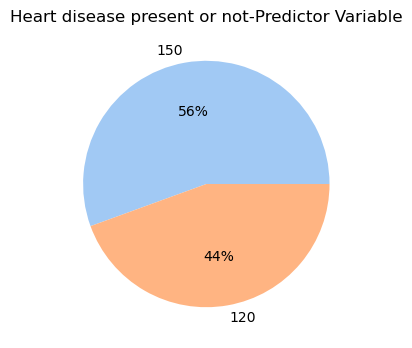

In [19]:
plt.figure(figsize=(6,4))
plt.title('Heart disease present or not-Predictor Variable')
plt.pie(x=df['Heart Disease_encoded'].value_counts(),labels=df['Heart Disease_encoded'].value_counts().values,
        colors=sns.color_palette('pastel')
        ,autopct='%.0f%%')

### Interpretation
There is around 11% imbalance in the target variable. As there is no major imbalance we can proceed with Model buiding

In [20]:
df_model.columns

Index(['index', 'Sex', 'FBS over 120', 'EKG results', 'Exercise angina',
       'ST depression', 'Number of vessels fluro', 'Heart Disease',
       'Heart Disease_encoded'],
      dtype='object')

### Model 1: Building Basic Model including all features

In [21]:
X_col = [ 'Sex','Chest pain type','BP',  'Cholesterol', 'Age','Thallium', 'Slope of ST',
       'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina',
       'ST depression',  'Number of vessels fluro']
X = df[X_col]
y = df['Heart Disease_encoded']

In [22]:
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [23]:
lrg_model = LogisticRegression()
lrg_model.fit(X_train,y_train)

LogisticRegression()

In [24]:
y_pred = lrg_model.predict(X_test)

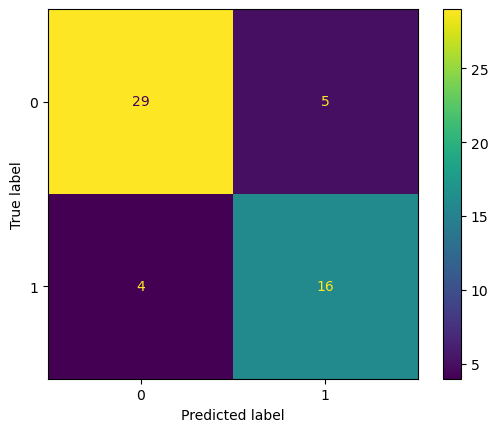

In [25]:
c_mat = confusion_matrix(y_test,y_pred)
display = ConfusionMatrixDisplay(c_mat,display_labels=lrg_model.classes_)
display.plot()

### Output       
               prediction      
               0       1    
             -----   -----  
          0 | TN   |  FP    
    actual   -----   -----  
          1 | FN   |  TP    

In [26]:
accuracy_score(y_test,y_pred)

0.8333333333333334

### Accuracy

       TP + TN
    ----------------
    TP + FP + TN + FN

In [27]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87        34
           1       0.76      0.80      0.78        20

    accuracy                           0.83        54
   macro avg       0.82      0.83      0.82        54
weighted avg       0.84      0.83      0.83        54



### Percision

Percision is all about how consistent your Model predictes, for the total predicted positive cases
    
         TP
      --------      
      TP + FP
      
### Recall / Sensitivity

Recall is how many positive cases your model predicted correctly out of total actual possitive cases
    
         TP
      --------      
      TP + FN

### Specificity

Specificity is how many negative cases the model predicted correctly out of total actual negative cases

        TN
      --------
      TN + FP
      
### F1 Score

             Recall * Percision
        2 * -------------------
             Recall + Percision

### Plotting Sigmoid Curve 

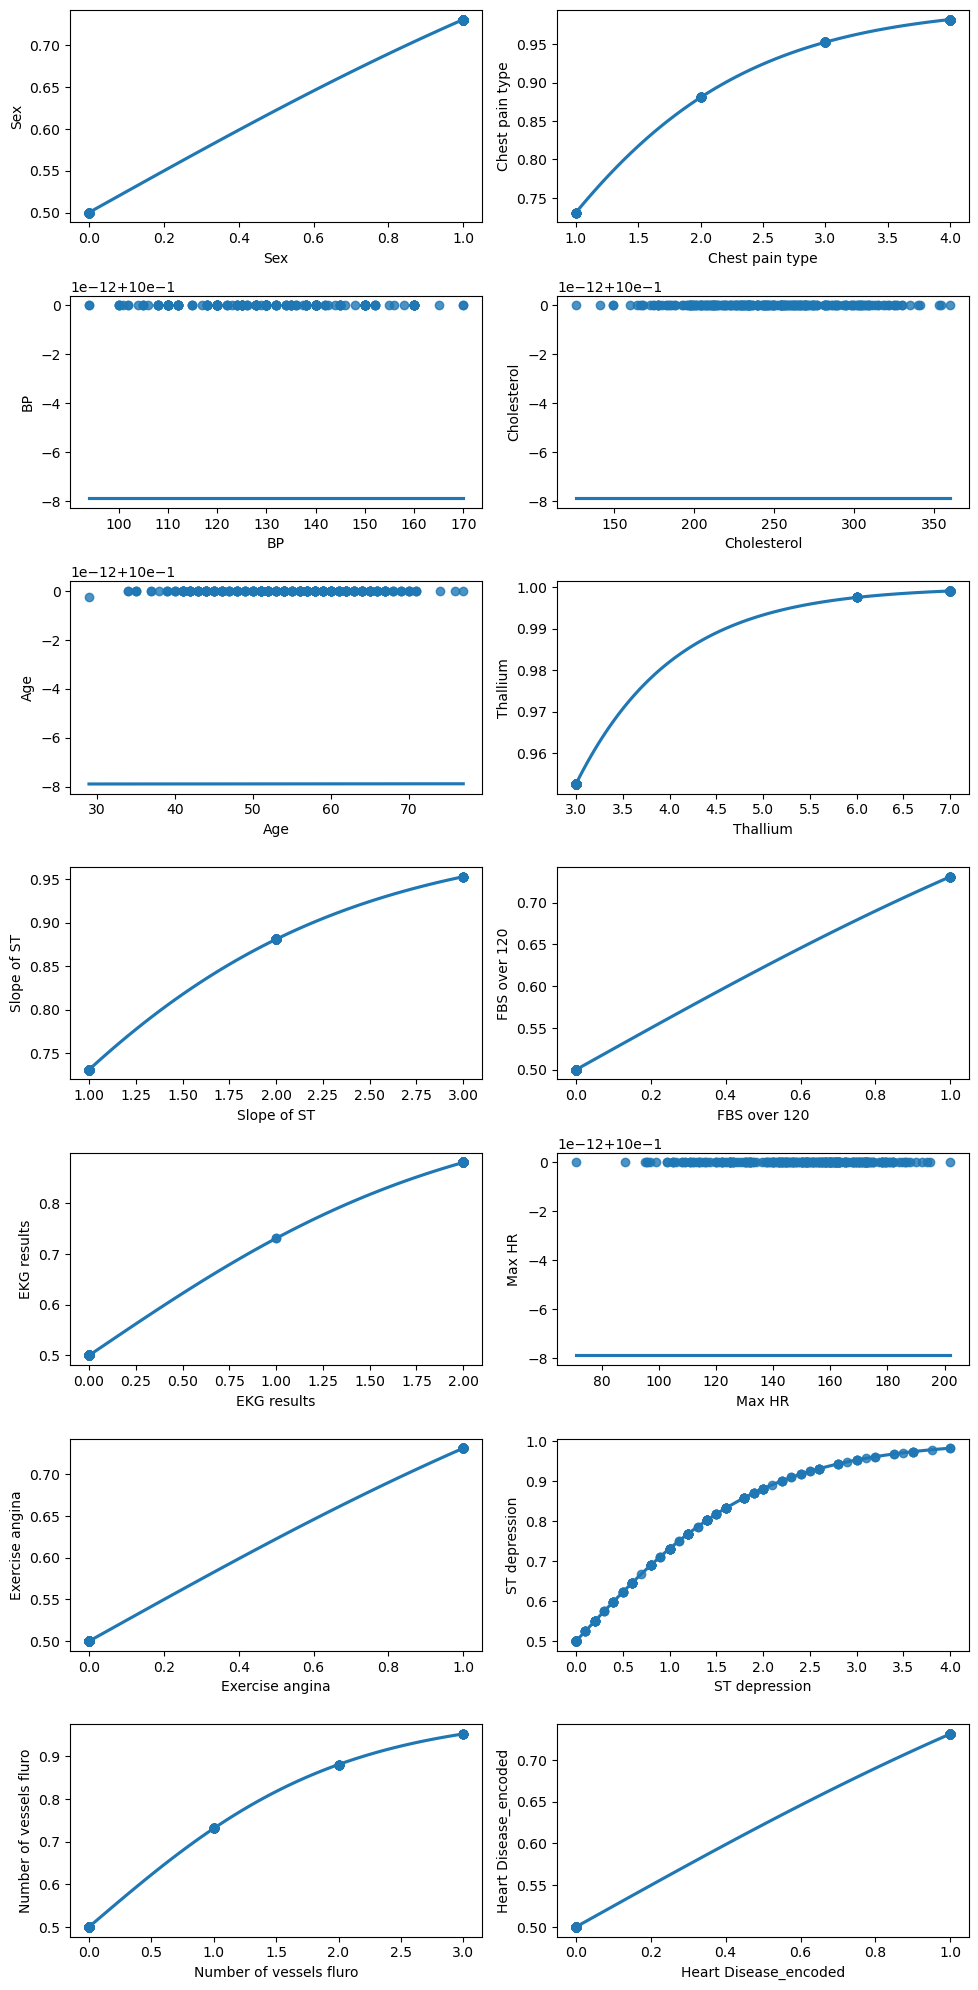

In [49]:
sig_cols = [ 'Sex','Chest pain type','BP',  'Cholesterol', 'Age','Thallium', 'Slope of ST',
       'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina',
       'ST depression',  'Number of vessels fluro','Heart Disease_encoded']
def sig_curve(x):
    return 1.0 / (1.0 + np.exp(-x))

fig, ax = plt.subplots(nrows = 7, ncols = 2,figsize = (10,20))
j = 0
k = 0
for i,col in enumerate(sig_cols):
    if i == 0:
        j = 0
        k = 0
    elif i%2 == 0:
        j += 1
        k = 0
    else:
        k += 1
    fig.tight_layout()      
    ax[j,k].set_ylabel(f'Sigmoid({col})')
    sns.regplot(x=df[col],y=sig_curve(df[col]),logistic=True,ci=None,ax= ax[j,k])

### Calculate ROC & AUC

In [71]:
model_prob = lrg_model.predict_proba(X_test)
fpr , tpr, thres = roc_curve(y_test,model_prob[:,1])
acuc_score = roc_auc_score(y_test,model_prob[:,1])
print('Threshold =',thres)
print(acuc_score)

Threshold = [inf  1.]
0.5


In [83]:
print('Regression Equation - Decision Boundary')
print(f"{lrg_model.intercept_[0]} + {lrg_model.coef_[0,0]} X1 + {lrg_model.coef_[0,1]} X2 + {lrg_model.coef_[0,2]} X3 \
      + {lrg_model.coef_[0,3]} X4 + {lrg_model.coef_[0,4]} X5 + {lrg_model.coef_[0,5]} X6 + {lrg_model.coef_[0,6]} X7 \
      + {lrg_model.coef_[0,7]} X4 + {lrg_model.coef_[0,8]} X5 + {lrg_model.coef_[0,9]} X6 + {lrg_model.coef_[0,10]} X7 \
      + {lrg_model.coef_[0,11]} X4 + {lrg_model.coef_[0,12]} X12 ")

Regression Equation - Decision Boundary
-4.632373231791032 + 0.9646927795785766 X1 + 1.5139479386008046 X2 + 0.6993335938630628 X3       + 1.1271803247521446 X4 + 0.1960452243688451 X5 + 1.4979674940536782 X6 + 0.8223788917146081 X7       + -0.2630458755945264 X4 + 0.2889818310139696 X5 + -0.7143112708617009 X6 + 1.196470809409531 X7       + 1.0515090779902931 X4 + 2.152552468715792 X12 


Text(0, 0.5, 'True Positive Rate')

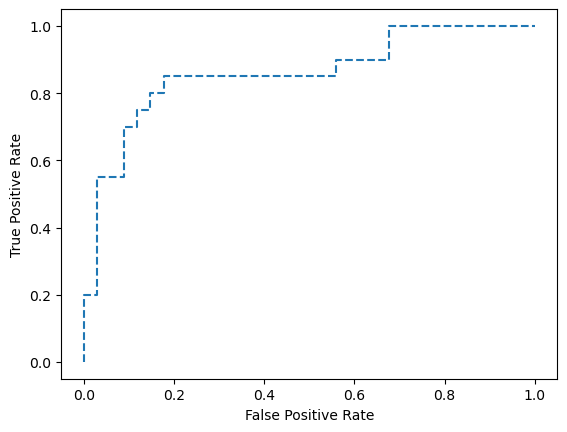

In [30]:
plt.plot(fpr,tpr,linestyle ='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### Interpretation

    1. Out of 54 cases the Model had preodicted 46 cases correctly (TP+TN) leading to accuracy of 85%
    2. The recall,percision and r2 score seems just above average for the given accuracy
    

### Model 2: Building Model including only features with VIF < 5

In [31]:
df_model.columns

Index(['index', 'Sex', 'FBS over 120', 'EKG results', 'Exercise angina',
       'ST depression', 'Number of vessels fluro', 'Heart Disease',
       'Heart Disease_encoded'],
      dtype='object')

In [32]:
X1 = df_model[[ 'Sex', 'FBS over 120', 'EKG results', 'Exercise angina',
       'ST depression', 'Number of vessels fluro']]
y1 = df_model['Heart Disease_encoded']

In [33]:
X1_train, X1_test,y1_train, y1_test = train_test_split(X1,y1,test_size=0.2,random_state=5)

In [34]:
lrg_model = LogisticRegression()
lrg_model.fit(X1_train,y1_train)

LogisticRegression()

In [35]:
y1_pred = lrg_model.predict(X1_test)

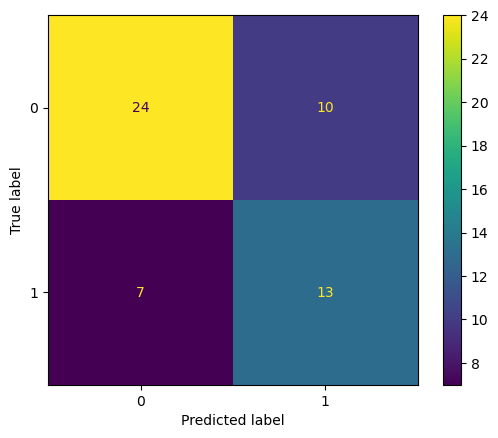

In [36]:
c_mat = confusion_matrix(y1_test,y1_pred)
display = ConfusionMatrixDisplay(c_mat,display_labels=lrg_model.classes_)
display.plot()

In [37]:
accuracy_score(y1_test,y1_pred)

0.6851851851851852

In [38]:
print(classification_report(y1_test,y1_pred))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74        34
           1       0.57      0.65      0.60        20

    accuracy                           0.69        54
   macro avg       0.67      0.68      0.67        54
weighted avg       0.70      0.69      0.69        54



### Interpretation

    1. Out of 54 cases the Model had preodicted 37 cases correctly (TP+TN) leading to accuracy of 64%. Which very low
    2. The recall,percision and r2 score seems just above average for the given accuracy. This is quite same as the above 
       model
    3. As the classes had 11% imbalance, the variation is accuracy is expected
    4. Conclusion both the model prediction seems fair 

### Model 3: Model with Scaled Data

In [39]:
scaler_cols = [ 'Sex','Chest pain type','BP',  'Cholesterol', 'Age','Thallium', 'Slope of ST',
       'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina',
       'ST depression',  'Number of vessels fluro']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[scaler_cols])
df_scaled = pd.DataFrame(data=scaled_data,columns=scaler_cols)

In [40]:
X2 = df_scaled[X_col]
y2 = df['Heart Disease_encoded']

In [41]:
X2_train, X2_test,y2_train, y2_test = train_test_split(X2,y2,test_size=0.2,random_state=5)

In [42]:
lrg_model = LogisticRegression()
lrg_model.fit(X2_train,y2_train)

LogisticRegression()

In [43]:
y2_pred = lrg_model.predict(X2_test)

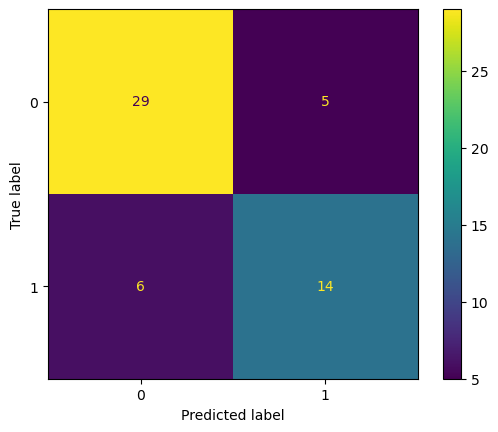

In [44]:
c_mat = confusion_matrix(y2_test,y2_pred)
display = ConfusionMatrixDisplay(c_mat,display_labels=lrg_model.classes_)
display.plot()

In [45]:
accuracy_score(y2_test,y2_pred)

0.7962962962962963

In [46]:
print(classification_report(y2_test,y2_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84        34
           1       0.74      0.70      0.72        20

    accuracy                           0.80        54
   macro avg       0.78      0.78      0.78        54
weighted avg       0.79      0.80      0.80        54



### Interpretation
    Scaling the features does not help for this data set,as the dataset scale does not have much variation. Out of scaling techniques StandardScaler,MaxAbsScaler,Normalizer, the MinMaxScaler gave the maxmimum accuracy of 79%. The recall and f1-score is however Good with 84%